In [1]:
import os
import yaml
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from pathlib import Path
from filetrials import FileTrials, space_eval
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback, EarlyStopping

# Import hyperopt modules
from hyperopt import hp, fmin, tpe

%matplotlib inline

In [2]:
# Fix the seeds for reproducible results
tf.random.set_seed(1234)
np.random.seed(5678)

In [3]:
current_path = Path().absolute()
hyperopt_path = current_path
fits_path = current_path / "fits"
fits_path.mkdir(exist_ok=True)
data_path = current_path / "data"
reps_path = current_path / "replicas"
reps_path.mkdir(exist_ok=True)
theory_path = current_path / "theory"

In [4]:
# load runcard with parameters
def load_runcard(filename):
    with open(f"{current_path}/" + filename, "r") as file:
        input_params = yaml.safe_load(file)
    return input_params

In [5]:
def split_mask(ndata, perc = 0.3):
    mask = np.ones(ndata, dtype = int)
    if ndata >= 3:
        size_val = round(ndata*perc)
        idx = np.random.choice(np.arange(1, ndata-1, 2), size_val, replace=False)
        mask[idx] = 0
    return mask

In [6]:
def load_data(runcard):
    df = pd.DataFrame()
    filenames = os.listdir(f"{data_path}")

    for i, filename in enumerate(filenames):
        with open(f"{data_path}/" + filename, "r") as file:
            input_data = yaml.safe_load(file)

        x = input_data["x"]
        Q2 = np.array(input_data["Q2"])
        F_2 = np.array(input_data["F_2"])
        F_2_err_stat = np.array(input_data["F_2_err_stat"])
        F_2_err_sys = np.array(input_data["F_2_err_sys"])

        if runcard["Q2_cut"] != str(None):
            Q2_mask = np.where(Q2 < runcard["Q2_cut"])
            Q2 = Q2[Q2_mask]
            F_2 = F_2[Q2_mask]
            F_2_err_stat = F_2_err_stat[Q2_mask]
            F_2_err_sys = F_2_err_sys[Q2_mask]

        if i == 0:
            ndata = len(Q2)
            x_0 = np.repeat(x, ndata)
            x_1 = Q2
            y = F_2
            y_err_stat = F_2_err_stat
            y_err_sys = F_2_err_sys
            mask = split_mask(ndata)

        else:
            ndata = len(Q2)
            x_0 = np.concatenate([x_0, np.repeat(x, ndata)])
            x_1 = np.concatenate([x_1, Q2])
            y = np.concatenate([y, F_2])
            y_err_stat = np.concatenate([y_err_stat, F_2_err_stat])
            y_err_sys = np.concatenate([y_err_sys, F_2_err_sys])
            mask = np.concatenate([mask, split_mask(ndata)])

    df["x_0"] = x_0
    df["x_1"] = x_1
    df["y"] = y
    df["y_err_stat"] = y_err_stat
    df["y_err_sys"] = y_err_sys
    df["mask"] = mask

    df.to_csv(f"{current_path}/DataFrame_{runcard['name']}.csv")

    return df

In [7]:
def model_trainer(data_df, **hyperparameters):
    # Collect the values for the hyperparameters
    optimizer = hyperparameters.get("optimizer", "adam")
    activation = hyperparameters.get("activation", "relu")
    epochs = hyperparameters.get("epochs", 10)
    nb_units_1 = hyperparameters.get("units_1", 64)
    nb_units_2 = hyperparameters.get("units_2", 32)
    initializer = hyperparameters.get("initializer", "random_normal")

    # Construct the model
    model = Sequential()
    model.add(
        Dense(
            units=nb_units_1,
            activation=activation,
            kernel_initializer=initializer,
            input_shape=[2],
        )
    )
    model.add(
        Dense(units=nb_units_2, activation=activation, kernel_initializer=initializer)
    )

    # output layer
    model.add(Dense(units=1, activation="linear", kernel_initializer=initializer))

    # Compile the Model as usual
    model.compile(loss="mse", optimizer=optimizer, metrics=["accuracy"])

    # Callbacks for Early Stopping
    ES = EarlyStopping(
        monitor="val_loss",
        mode="min",
        verbose=0,
        patience=10,
        restore_best_weights=True,
    )

    # extract data
    x_tr = data_df[data_df["mask"] == 1][["x_0", "x_1"]].to_numpy()
    x_val = data_df[data_df["mask"] == 0][["x_0", "x_1"]].to_numpy()
    y_tr = data_df[data_df["mask"] == 1]["y"].to_numpy()
    y_val = data_df[data_df["mask"] == 0]["y"].to_numpy()

    # Fit the Model as usual
    model.fit(
        x_tr,
        y_tr,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=1,
        verbose=0,
        callbacks=[ES],
    )

    # Evaluate the Model on the test. Note that this will be the
    # parameter to hyperoptimize. If one wants, one could use x/y_tr.
    # This might be ideal if one have very small number of datapoints
    scores = model.evaluate(x_val, y_val, verbose=0)
    # Return the value of the validation loss
    return model, scores[0]

In [8]:
def define_hyperspace(runcard):
    activation = hp.choice("activation", runcard["activation_choices"])
    optimizer = hp.choice("optimizer", runcard["optimizer_choices"])
    epochs = hp.choice("epochs", runcard["epochs_choices"])
    initializer = hp.choice("initializer", runcard["initializer_choices"])
    nb_units_1 = runcard["nb_units_1"]
    nb_units_2 = runcard["nb_units_2"]
    units_1 = hp.quniform(
        "units_1", nb_units_1["min"], nb_units_1["max"], nb_units_1["stepsize"]
    )
    units_2 = hp.quniform(
        "units_2", nb_units_2["min"], nb_units_2["max"], nb_units_2["stepsize"]
    )

    return {
        "activation": activation,
        "optimizer": optimizer,
        "epochs": epochs,
        "initializer": initializer,
        "units_1": units_1,
        "units_2": units_2,
    }

In [9]:
def perform_hyperopt(data_df, runcard):
    hyperspace = define_hyperspace(runcard)

    # Define the hyperoptimization function
    def hyper_function(hyperspace_dict):
        _, val_loss = model_trainer(data_df, **hyperspace_dict)
        return {"loss": val_loss, "status": "ok"}

    trials = FileTrials(hyperopt_path, runcard["name"], parameters=hyperspace)
    best = fmin(
        fn=hyper_function,
        space=hyperspace,
        verbose=1,
        max_evals=runcard["nb_trials"],
        algo=tpe.suggest,
        trials=trials,
    )
    # Save the best hyperparameters combination in order to return it later
    best_setup = space_eval(hyperspace, best)
    # Write the output of the best into a file
    with open(
        f"{hyperopt_path}/best_hyperparameters_{runcard['name']}.yaml", "w"
    ) as file:
        yaml.dump(best_setup, file, default_flow_style=False)
    # Write the all the history of the hyperopt into a file
    with open(
        f"{hyperopt_path}/hyperopt_history_{runcard['name']}.pickle", "wb"
    ) as histfile:
        pickle.dump(trials.trials, histfile)
    return best_setup

In [10]:
runcard = load_runcard("runcard.yaml")

In [11]:
data_df = load_data(runcard)

In [12]:
best_params = perform_hyperopt(data_df, runcard)

  0%|                                     | 0/2 [00:00<?, ?trial/s, best loss=?]

2022-05-03 15:46:08.353747: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-03 15:46:08.355019: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-03 15:46:08.509045: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-03 15:46:08.534679: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


100%|█████████| 2/2 [00:24<00:00, 12.47s/trial, best loss: 0.004114765208214521]


In [13]:
def plot_constant_x(best_model, data_df):
    # loop over x values
    x_set = set(data_df["x_0"])
    for x_value in x_set:
        x_df = data_df[data_df["x_0"]==x_value]
        x = x_df[["x_0", "x_1"]].to_numpy()
        y = x_df["y"].to_numpy()
        x_grid = np.linspace(x[0], x[-1], 100)
        y_pred = best_model(x_grid)
        
        fig, ax = plt.subplots(1, 1) 
        ax.plot(x_grid[:, 1], y_pred, color="red", label="Prediction")
        ax.scatter(x[:, 1], y, color="blue", label="Data")
        ax.legend()
        ax.set_xlabel("$Q^2$ [GeV$^2$]")
        ax.set_ylabel("$F_2$")
        ax.set_title(f"Prediction of $F_2$ at $x={x[0,0]}$")
        plt.show()
        plt.savefig(f"{fits_path}/FIT_{x[0,0]}.png")
        ax.clear()

In [14]:
def load_best_parameters(name):
    with open(f"{hyperopt_path}/best_hyperparameters_{name}.yaml", "r") as file:
        best_params = yaml.safe_load(file)
    return best_params

In [16]:
best_params = load_best_parameters(runcard["name"])

In [17]:
best_model,_ = model_trainer(data_df, **best_params)

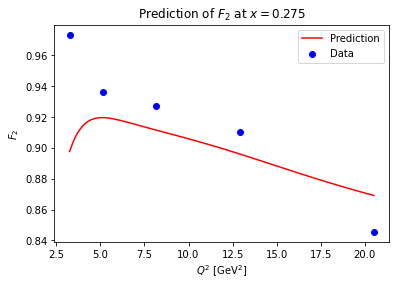

<Figure size 432x288 with 0 Axes>

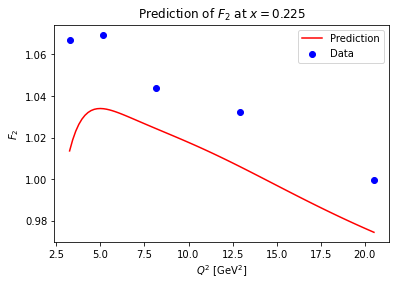

<Figure size 432x288 with 0 Axes>

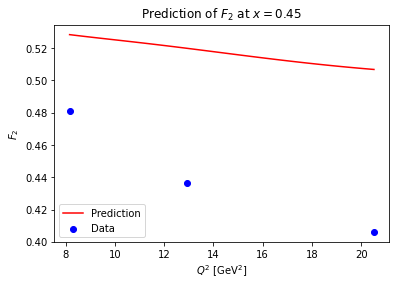

<Figure size 432x288 with 0 Axes>

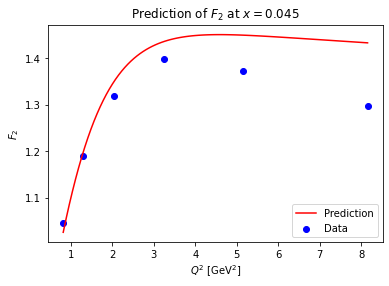

<Figure size 432x288 with 0 Axes>

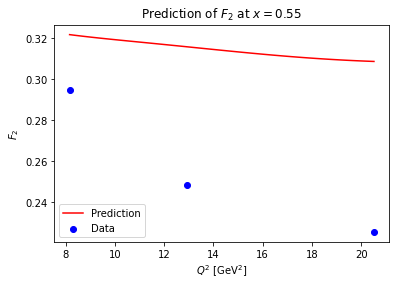

<Figure size 432x288 with 0 Axes>

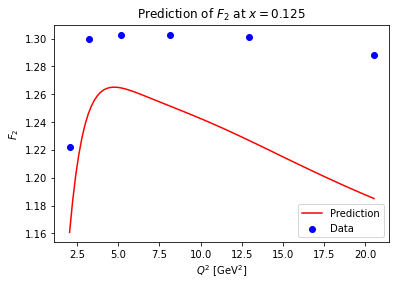

<Figure size 432x288 with 0 Axes>

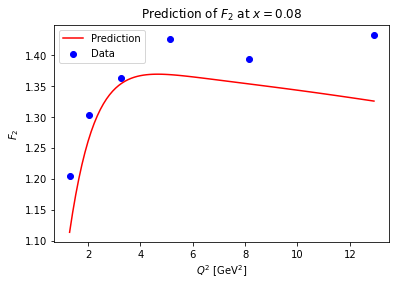

<Figure size 432x288 with 0 Axes>

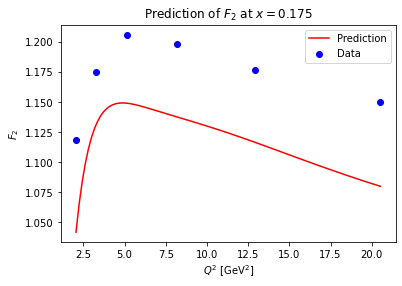

<Figure size 432x288 with 0 Axes>

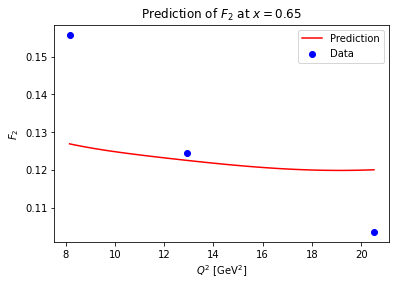

<Figure size 432x288 with 0 Axes>

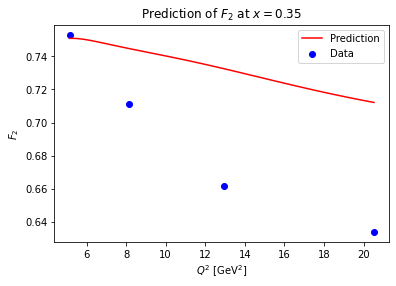

<Figure size 432x288 with 0 Axes>

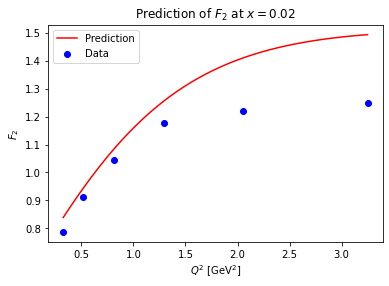

<Figure size 432x288 with 0 Axes>

In [18]:
plot_constant_x(best_model, data_df)

In [19]:
def create_replicas(data_df, n_rep):
    
    y = data_df["y"].to_numpy()
    y_err = data_df["y_err_sys"].to_numpy() + data_df["y_err_stat"].to_numpy()
    y_dist = np.zeros((n_rep, y.shape[0]))
    for i, mean in enumerate(y):
        y_dist[:, i] = np.random.normal(
            loc=mean,
            scale=(y_err[i]),
            size=n_rep,
        ) 
    for i, y in enumerate(y_dist):
        np.save(f"{reps_path}/rep_{i+1}.npy", y)

In [20]:
def fit_replica(data_df, filename, best_params):
    y = np.load(f"{reps_path}/{filename}")
    
    new_data_df = data_df.copy()
    new_data_df["y"] = y
    model,_ = model_trainer(new_data_df, **best_params)
    
    # make prediction looping over x values
    x_set = set(data_df["x_0"])
    n_grid = 100
    data_pred = np.empty((len(x_set), n_grid, 3))
    for i, x_value in enumerate(x_set):
        x_df = data_df[data_df["x_0"]==x_value]
        x = x_df[["x_0", "x_1"]].to_numpy()
        y = x_df["y"].to_numpy()
        y_err = x_df["y_err_stat"].to_numpy() + x_df["y_err_sys"].to_numpy()
        x_grid = np.linspace(x[0], x[-1], n_grid)
   
        y_pred = model.predict(x_grid)
        
        data_pred[i,:,:2] = x_grid
        data_pred[i,:,2] = y_pred.reshape(-1)
    
    np.save(f"{reps_path}/PRED_{filename}", data_pred)

In [58]:
def plot_with_reps(n_reps, data_df, theory_df):
    # loop over x values
    x_set = set(data_df["x_0"])
    ratios = []
    for x_idx, x_value in enumerate(x_set):
        x_df = data_df[data_df["x_0"]==x_value]
        x = x_df[["x_0", "x_1"]].to_numpy()
        y = x_df["y"].to_numpy()
        y_err = x_df["y_err_stat"].to_numpy() + x_df["y_err_sys"].to_numpy()
        
        x_theory_df = theory_df[theory_df["x"]==x_value]
        x_theory = x_theory_df["Q2"]
        y_theory = x_theory_df["F2"]
        err_theory = x_theory_df["err"]
        
        ratios.append(list(np.array(y_theory) / y))
        
        # loop over replicas
        y_pred = []
        for rep_idx in range(n_reps):
            data_pred = np.load(f"{reps_path}/PRED_rep_{rep_idx+1}.npy")
            y_pred.append(data_pred[x_idx,:, 2])
        x_grid = data_pred[x_idx,:,:2]
        
        # compute mean and errorbands
        p1_high = np.nanpercentile(y_pred,84,axis=0)
        p1_low = np.nanpercentile(y_pred,16,axis=0)
        p1_mid = (p1_high + p1_low )/2.
        p1_error = (p1_high - p1_low )/2.
        
        p1_mid = p1_mid.reshape(-1)
        p1_error = p1_error.reshape(-1)
        
        # plot
        _, ax = plt.subplots(1, 1) 
        ax.errorbar(x[:, 1], y, yerr=y_err, label = "Data", fmt="ko", capsize=5)
        ax.fill_between(x_grid[:, 1], y1=p1_mid-p1_error, y2=p1_mid+p1_error, color="red", edgecolor="red", label="Prediction", alpha=0.25)
        ax.plot(x_grid[:, 1], p1_mid, color="red", linestyle="dashed")
        ax.set_xlabel("$Q^2$ [GeV$^2$]")
        ax.set_ylabel("$F_2$")
        ax.set_title(f"Prediction of $F_2$ at $x={x[0,0]}$")
        ax.errorbar(x_theory, y_theory, yerr=err_theory, label="Theory", fmt="go")
        ax.legend()
        plt.show()
        plt.savefig(f"{fits_path}/FIT_{x[0,0]}.png")
        ax.clear()
        
    print(ratios)

In [22]:
n_reps = 5
create_replicas(data_df, n_reps)

In [23]:
for i in range(n_reps):
    fit_replica(data_df, f"rep_{i+1}.npy", best_params)

In [60]:
theory_df = load_theory()

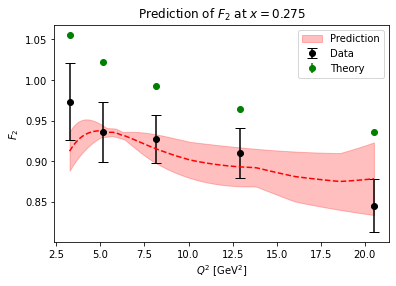

<Figure size 432x288 with 0 Axes>

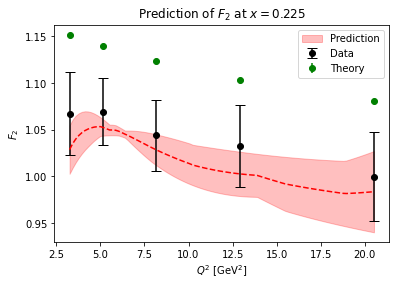

<Figure size 432x288 with 0 Axes>

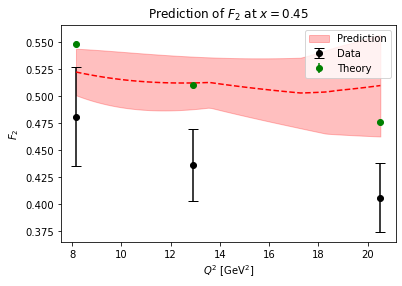

<Figure size 432x288 with 0 Axes>

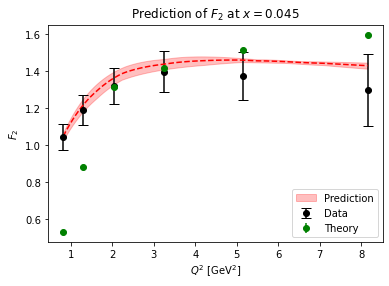

<Figure size 432x288 with 0 Axes>

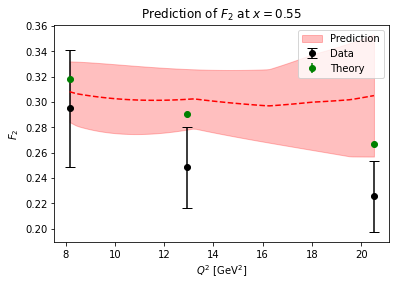

<Figure size 432x288 with 0 Axes>

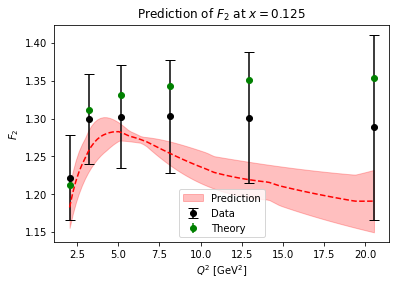

<Figure size 432x288 with 0 Axes>

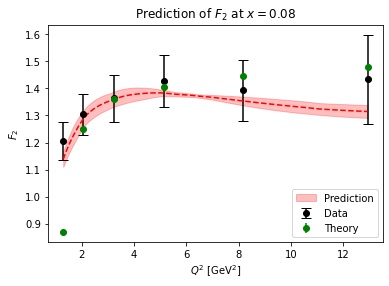

<Figure size 432x288 with 0 Axes>

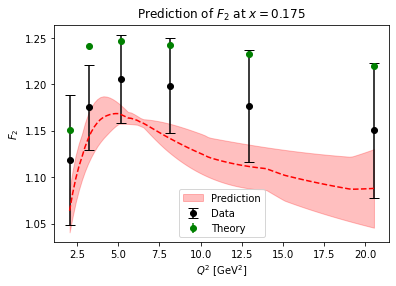

<Figure size 432x288 with 0 Axes>

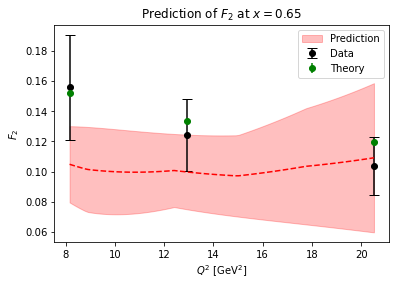

<Figure size 432x288 with 0 Axes>

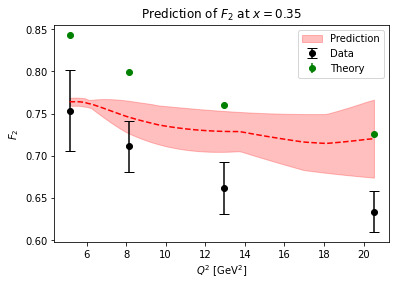

<Figure size 432x288 with 0 Axes>

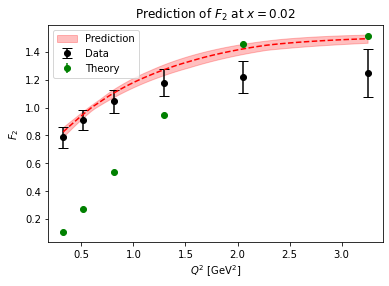

[[1.0846639103187268, 1.091390352704011, 1.0704700809859062, 1.05927862836059, 1.1067191324347696], [1.0796269556286588, 1.0659459847052346, 1.0759927938170293, 1.068303557151969, 1.080683225557565], [1.1403174836448802, 1.169460846133643, 1.171508799785062], [0.5075507769152633, 0.7404707959567038, 0.9956761956644383, 1.0150650933522387, 1.103199343739855, 1.231546393899655], [1.0787280630040743, 1.1702024574466818, 1.1829342444693707], [0.9919663169013923, 1.0091644427300206, 1.0220847552578312, 1.0312530022747388, 1.0380097167934477, 1.050883985898761], [0.720980228150302, 0.9582535127790393, 0.9981474500017106, 0.9859988820322169, 1.0380564812798887, 1.0328999238329204], [1.0291393667176185, 1.0562674823332325, 1.0335948718149028, 1.0365484997080465, 1.047325342752253, 1.060219856057974], [0.9765621350921871, 1.0752274271616442, 1.1560198003175892], [1.1199256953004053, 1.1236533776707929, 1.1481734105525037, 1.1443095388607394], [0.1329284130807512, 0.30010221473057935, 0.51743938

<Figure size 432x288 with 0 Axes>

In [61]:
plot_with_reps(n_reps, data_df, theory_df)

In [47]:
def load_theory():
    with open(f"{theory_path}/DataGrid_NNPDF40_nnlo_as_01180.yaml", "r") as file:
        theory = yaml.safe_load(file)
    theory_df = pd.DataFrame()
    theory_df["x"] = list(theory["F2_total"]["x"].values())
    theory_df["Q2"] = list(theory["F2_total"]["Q2"].values())
    theory_df["F2"] = list(theory["F2_total"]["result"].values())
    theory_df["err"] = list(theory["F2_total"]["error"].values())
    return theory_df

In [49]:
theory_df

,x,Q2,F2,err
0,0.275,3.250,0.652949,1.194825e-07
1,0.275,5.146,0.624826,9.242254e-08
2,0.275,8.155,0.603959,7.356338e-08
3,0.275,12.925,0.584112,5.912768e-08
4,0.275,20.520,0.564389,4.898285e-08
5,0.020,0.325,0.079565,5.063355e-08
6,0.020,0.515,0.235989,4.204677e-08
7,0.020,0.816,0.478315,4.217706e-08
8,0.020,1.293,0.843978,4.645505e-08
9,0.020,2.052,1.316740,4.902246e-08


In [ ]:
x = theory["F2_total"]["x"]
    
    if i == 0:
        ndata = len(Q2)
        x_0 = np.repeat(x, ndata)
        x_1 = Q2
        y = F_2
        y_err_stat = F_2_err_stat
        y_err_sys = F_2_err_sys
        mask = split_mask(ndata)

    else:
        ndata = len(Q2)
        x_0 = np.concatenate([x_0, np.repeat(x, ndata)])
        x_1 = np.concatenate([x_1, Q2])
        y = np.concatenate([y, F_2])
        y_err_stat = np.concatenate([y_err_stat, F_2_err_stat])
        y_err_sys = np.concatenate([y_err_sys, F_2_err_sys])
        mask = np.concatenate([mask, split_mask(ndata)])

    df["x_0"] = x_0
    df["x_1"] = x_1
    df["y"] = y
    df["y_err_stat"] = y_err_stat

In [27]:
theory_dict

{'x': 0.275,
 'Q2': [3.25, 5.146, 8.155, 12.925, 20.52],
 'F2': [0.652948639786562,
  0.6248256681336768,
  0.6039589749930848,
  0.5841122917917341,
  0.5643887950445118],
 'error': [1.1948254755995412e-07,
  9.24225372138466e-08,
  7.356337621889451e-08,
  5.912768365549086e-08,
  4.8982846870977946e-08]}

In [48]:
df = pd.DataFrame()
df["x"] = data_df["x_0"]
df["Q2"] = data_df["x_1"]

In [49]:
df.to_csv(f"{theory_path}/DataGrid.csv")

In [58]:
pred_df = pd.DataFrame()
ndata = 100
x_values = [0.05, 0.1,  0.25, 0.6]
Q2_grid = np.linspace(3, 30, ndata)
xQ2_array = np.empty((len(x_values)*ndata,2))
for i,x in enumerate(x_values):
    xQ2_array[ndata*i:ndata*(i+1), 0] = x
    xQ2_array[ndata*i:ndata*(i+1), 1] = Q2_grid
pred_df["x"] = xQ2_array[:,0]
pred_df["Q2"] = xQ2_array[:,1]

In [61]:
pred_df.to_csv(f"{theory_path}/PredictionGrid.csv")

In [64]:
# kinematic plot
runcard_comp = load_runcard("runcard_complete.yaml")
data_comp = load_data(runcard_comp)

Text(0, 0.5, '$Q^2$ [GeV$^2$]')

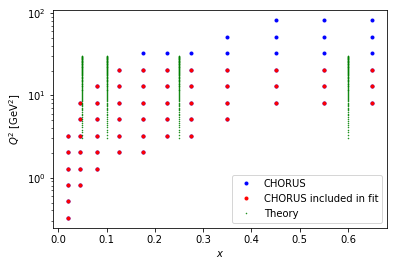

In [108]:
plt.plot(data_comp["x_0"], data_comp["x_1"], "b.", label="CHORUS")
plt.plot(data_df["x_0"], data_df["x_1"], "r.", label="CHORUS included in fit")
plt.plot(pred_df["x"], pred_df["Q2"], "g.", markersize=1, label="Theory")
plt.legend()
plt.xlabel("$x$")
plt.yscale("log")
plt.ylabel("$Q^2$ [GeV$^2$]")

Text(0, 0.5, '$Q^2$ [GeV$^2$]')

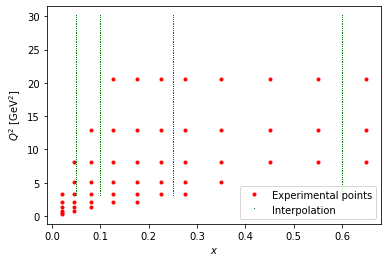

In [78]:
plt.plot(df["x"], df["Q2"], "r.", label="Experimental points")
plt.plot(pred_df["x"], pred_df["Q2"], "g,", label="Interpolation")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$Q^2$ [GeV$^2$]")